In [1]:
# Import necessary libraries
import os
from google.colab import drive
from google.colab import files
from IPython.display import Image
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
import gensim
import ktrain
import torch
import os
import re
import pandas as pd
import numpy as np
import gensim.downloader as api
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from gensim.models import KeyedVectors
from gensim.similarities import WmdSimilarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, r2_score
from rank_bm25 import BM25Okapi
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sentence_transformers import SentenceTransformer, util
from torch.utils.data import DataLoader, Dataset, RandomSampler
from ktrain import text
from absl import logging

nltk.download('punkt')
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)
# uploaded = files.upload()

ModuleNotFoundError: ignored

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [ ]:
os.chdir('/content/drive/MyDrive/NLP Project')
os.getcwd()

In [ ]:
!pip install rank_bm25
!pip install transformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm import tqdm

In [7]:
# Load the data
columns = ['Source', 'Category', 'Year', 'ID', 'Similarity', 'Sentence1', 'Sentence2']
try:
  train_df = pd.read_csv("data/sts-train-clean.csv", names=columns, index_col=False)
  test_df = pd.read_csv("data/sts-test-clean.csv", names=columns, index_col=False)
  dev_df = pd.read_csv("data/sts-dev-clean.csv", names=columns, index_col=False) 
except pd.errors.ParserError:
    # Handle the error if the number of columns is unexpected
    print("Error: Unexpected number of columns in the data. Ignoring the problematic rows.")
    train_df = pd.read_csv("data/sts-train-clean.csv", error_bad_lines=False, names=columns, index_col=False)
    test_df = pd.read_csv("data/sts-test-clean.csv", error_bad_lines=False, names=columns, index_col=False)
    dev_df = pd.read_csv("data/sts-dev-clean.csv", error_bad_lines=False, names=columns, index_col=False)



Error: Unexpected number of columns in the data. Ignoring the problematic rows.


<ipython-input-7-d03fccb02924>:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_df = pd.read_csv("data/sts-train-clean.csv", error_bad_lines=False, names=columns, index_col=False)
Skipping line 2511: expected 8 fields, saw 9
Skipping line 2652: expected 8 fields, saw 9
Skipping line 2889: expected 8 fields, saw 10
Skipping line 3224: expected 8 fields, saw 9
Skipping line 3277: expected 8 fields, saw 11

<ipython-input-7-d03fccb02924>:10: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  train_df = pd.read_csv("data/sts-train-clean.csv", error_bad_lines=False, names=columns, index_col=False)
<ipython-input-7-d03fccb02924>:11: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_df = pd.read_csv("data/sts-test-clean.csv",

## EDA

In [27]:
df = pd.concat([train_df, test_df, test_df], ignore_index=True)[['Sentence1', 'Sentence2', 'Similarity']]

In [28]:

# 2. Inspecting the dataset
print(df.head())
print(df.info())
print(df.describe())

                                       Sentence1  \
0                         A plane is taking off.   
1                A man is playing a large flute.   
2  A man is spreading shreded cheese on a pizza.   
3                   Three men are playing chess.   
4                    A man is playing the cello.   

                                           Sentence2  Similarity  
0                        An air plane is taking off.        5.00  
1                          A man is playing a flute.        3.80  
2  A man is spreading shredded cheese on an uncoo...        3.80  
3                         Two men are playing chess.        2.60  
4                 A man seated is playing the cello.        4.25  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8468 entries, 0 to 8467
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sentence1   8468 non-null   object 
 1   Sentence2   8467 non-null   object 
 2   Similarity

In [29]:

# 3. Checking for Missing Values
df_cleaned = df.dropna().reset_index()


In [30]:

# 4. Sentence Length Analysis
df_cleaned['Sentence1_length'] = df_cleaned['Sentence1'].apply(lambda x: len(str(x).split()))
df_cleaned['Sentence2_length'] = df_cleaned['Sentence2'].apply(lambda x: len(str(x).split()))
print(df_cleaned[['Sentence1_length', 'Sentence2_length']].describe())


       Sentence1_length  Sentence2_length
count       8467.000000       8467.000000
mean           9.867131          9.969883
std            5.324166          8.227507
min            3.000000          2.000000
25%            6.000000          6.000000
50%            8.000000          8.000000
75%           11.000000         12.000000
max           56.000000        415.000000


## Models

In [ ]:
print(train_df.columns)

Index(['Source', 'Category', 'Year', 'ID', 'Similarity', 'Sentence1',
       'Sentence2'],
      dtype='object')


In [ ]:
train_df.head()

,Source,Category,Year,ID,Similarity,Sentence1,Sentence2
0,main-captions,MSRvid,2012test,1,5.00,A plane is taking off.,An air plane is taking off.
1,main-captions,MSRvid,2012test,4,3.80,A man is playing a large flute.,A man is playing a flute.
2,main-captions,MSRvid,2012test,5,3.80,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...
3,main-captions,MSRvid,2012test,6,2.60,Three men are playing chess.,Two men are playing chess.
4,main-captions,MSRvid,2012test,9,4.25,A man is playing the cello.,A man seated is playing the cello.


In [ ]:
train_df['Similarity'].unique()

array([5.        , 3.8       , 2.6       , 4.25      , 0.5       ,
       1.6       , 2.2       , 4.2       , 4.6       , 3.867     ,
       4.667     , 1.667     , 3.75      , 3.2       , 2.8       ,
       3.        , 4.8       , 4.        , 4.909     , 2.4       ,
       3.4       , 2.75      , 3.6       , 1.75      , 1.        ,
       2.375     , 4.4       , 4.75      , 1.556     , 3.938     ,
       3.5       , 1.4       , 3.833     , 0.6       , 2.917     ,
       2.        , 0.8       , 1.643     , 2.25      , 4.857     ,
       2.533     , 0.143     , 2.5       , 0.        , 0.4       ,
       0.667     , 4.133     , 1.2       , 3.765     , 3.941     ,
       0.25      , 3.25      , 0.75      , 1.5       , 0.2       ,
       3.111     , 1.286     , 1.8       , 0.85      , 3.923     ,
       1.25      , 0.833     , 0.333     , 3.333     , 4.333     ,
       2.667     , 0.417     , 2.818     , 3.533     , 0.643     ,
       1.583     , 1.778     , 3.667     , 2.333     , 1.7    

In [ ]:
device = torch.device('cuda')

Train dataset size: 5710
Test dataset size: 1379
Dev dataset size: 1466


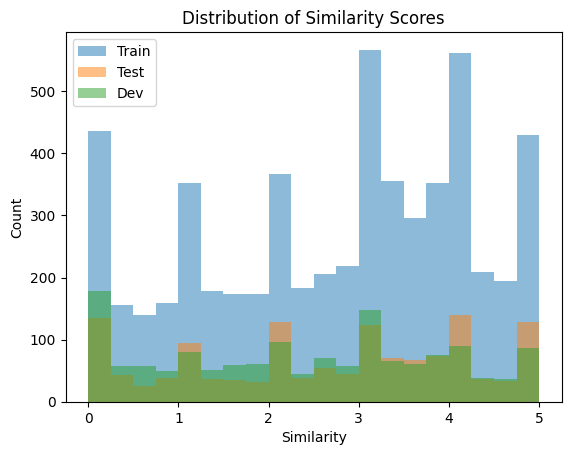

In [ ]:
# Visualize some statistics
print("Train dataset size:", len(train_df))
print("Test dataset size:", len(test_df))
print("Dev dataset size:", len(dev_df))
# Visualize some statistics
# Filter out rows with non-binable values
train_df['Similarity'] = pd.to_numeric(train_df['Similarity'], errors='coerce')
train_df = train_df.dropna(subset=['Similarity'])

test_df['Similarity'] = pd.to_numeric(test_df['Similarity'], errors='coerce')
test_df = test_df.dropna(subset=['Similarity'])

dev_df['Similarity'] = pd.to_numeric(dev_df['Similarity'], errors='coerce')
dev_df = dev_df.dropna(subset=['Similarity'])

# Plot the histogram
plt.hist(train_df['Similarity'], bins=20, alpha=0.5, label='Train')
plt.hist(test_df['Similarity'], bins=20, alpha=0.5, label='Test')
plt.hist(dev_df['Similarity'], bins=20, alpha=0.5, label='Dev')
plt.xlabel('Similarity')
plt.ylabel('Count')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.show()


In [ ]:
# Creating sets

train_sentences = train_df[['Sentence1', 'Sentence2']].values.tolist()
train_labels = train_df['Similarity'].values.tolist()

val_sentences = dev_df[['Sentence1', 'Sentence2']].values.tolist()
val_labels = dev_df['Similarity'].values.tolist()

test_sentences = test_df[['Sentence1', 'Sentence2']].values.tolist()
test_labels = test_df['Similarity'].values.tolist()

In [ ]:
# Define a custom dataset for loading the data
class STSDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence1 = str(self.sentences[idx][0])
        sentence2 = str(self.sentences[idx][1])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            sentence1,
            sentence2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }


In [ ]:

# Set up the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Set the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

cuda


In [ ]:

# Define hyperparameters
batch_size = 16
max_length = 128
epochs = 5
learning_rate = 2e-5

In [ ]:
# Create data loaders
train_dataset = STSDataset(train_sentences, train_labels, tokenizer, max_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = STSDataset(val_sentences, val_labels, tokenizer, max_length)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

test_dataset = STSDataset(test_sentences, test_labels, tokenizer, max_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:

# Move the model to the device
model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss()

In [ ]:

# Training loop

losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc='Epoch {}/{}'.format(epoch+1, epochs)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print('Epoch {}/{} - Loss: {:.4f}'.format(epoch+1, epochs, epoch_loss))


Epoch 1/5:   8%|▊         | 28/357 [00:13<01:52,  2.91it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1/5:  23%|██▎       | 82/357 [00:31<01:32,  2.97it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some toke

Epoch 1/5 - Loss: 1.2369


Epoch 2/5:   5%|▌         | 19/357 [00:06<02:02,  2.75it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 2/5:  14%|█▍        | 51/357 [00:18<01:49,  2.80it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some toke

Epoch 2/5 - Loss: 0.4838


Epoch 3/5:   8%|▊         | 30/357 [00:10<02:00,  2.72it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 3/5:  13%|█▎        | 46/357 [00:16<01:51,  2.78it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some toke

Epoch 3/5 - Loss: 0.3063


Epoch 4/5:   4%|▍         | 14/357 [00:05<02:02,  2.79it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 4/5:  23%|██▎       | 81/357 [00:29<01:40,  2.76it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some toke

Epoch 4/5 - Loss: 0.2198


Epoch 5/5:  12%|█▏        | 44/357 [00:15<01:54,  2.74it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 5/5:  42%|████▏     | 151/357 [00:54<01:14,  2.76it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tok

Epoch 5/5 - Loss: 0.1573


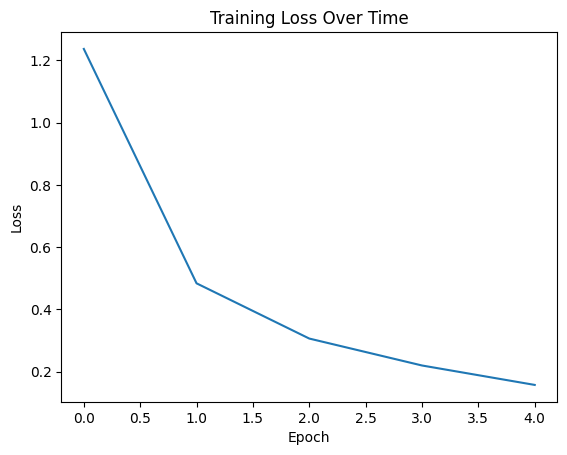

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

In [ ]:

# Evaluation
model.eval()
val_predictions = []
val_targets = []

In [ ]:
with torch.no_grad():
    for batch in tqdm(val_loader, desc='Evaluating'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze()

        val_predictions.extend(logits.tolist())
        val_targets.extend(labels.tolist())


Evaluating: 100%|██████████| 92/92 [00:12<00:00,  7.29it/s]


In [ ]:
# Calculate evaluation metrics
mse = mean_squared_error(val_targets, val_predictions)
mae = mean_absolute_error(val_targets, val_predictions)

print('Mean Squared Error: {:.4f}'.format(mse))
print('Mean Absolute Error: {:.4f}'.format(mae))

Mean Squared Error: 0.5842
Mean Absolute Error: 0.5722


Evaluating: 100%|██████████| 87/87 [00:11<00:00,  7.65it/s]


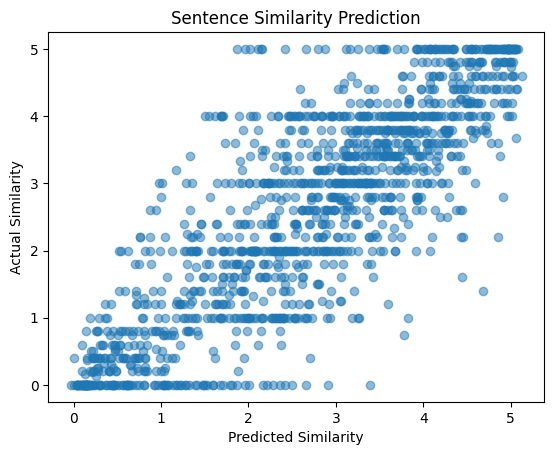

In [ ]:
# Evaluate the model on the test set
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits.squeeze()

        test_predictions.extend(logits.tolist())

# Convert similarity scores to lists
test_predictions_list = test_predictions


# Create a scatter plot
plt.scatter(test_predictions_list, test_labels, alpha=0.5)
plt.xlabel('Predicted Similarity')
plt.ylabel('Actual Similarity')
plt.title('Sentence Similarity Prediction')
plt.show()



## Finding out what kind of sentences that the model is struggling with

In [ ]:
# Calculate average word embeddings for the dataset
embeddings = []  # List to store the word embeddings
sentences = []  # List to store the sentences

# Iterate through the dataset and collect the sentences and their corresponding word embeddings
for row in train_df:
    sentence = row['Sentence']
    sentence_embedding = get_sentence_embedding(sentence)  # Replace with your own function to get word embeddings
    
    sentences.append(sentence)
    embeddings.append(sentence_embedding)

average_embedding = np.mean(embeddings, axis=0)  # Calculate the average embedding for the dataset

# Compare each sentence's embedding with the average embedding using cosine similarity
similarities = cosine_similarity(embeddings, [average_embedding])

# Find the indices of sentences that have low similarity with the average embedding
threshold = 0.8  # Adjust the threshold as per your requirement
struggling_indices = np.where(similarities < threshold)[0]

# Print the sentences that are struggling based on the defined attribute
for idx in struggling_indices:
    print(sentences[idx])

NameError: ignored